In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl

%matplotlib inline

### Load image data

In [1]:
import kaggle

kaggle.api.authenticate()

kaggle.api.dataset_download_files('gpiosenka/100-bird-species', path='.', unzip=True)

In [4]:
# Create directory variables for train and valid datasets
train_dir = 'train/'
valid_dir = 'valid/'

In [5]:
# define parameters for the loader
batch_size = 128
img_height = 224
img_width = 224

In [6]:
# Set up the train and valid datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 58388 files belonging to 400 classes.


2022-05-17 11:12:48.761729: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
valid_ds = tf.keras.utils.image_dataset_from_directory(
  valid_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2000 files belonging to 400 classes.


In [8]:
class_names = train_ds.class_names
print(class_names)

['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO', 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'ALBATROSS', 'ALBERTS TOWHEE', 'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH', 'ALTAMIRA YELLOWTHROAT', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART', 'AMETHYST WOODSTAR', 'ANDEAN GOOSE', 'ANDEAN LAPWING', 'ANDEAN SISKIN', 'ANHINGA', 'ANIANIAU', 'ANNAS HUMMINGBIRD', 'ANTBIRD', 'ANTILLEAN EUPHONIA', 'APAPANE', 'APOSTLEBIRD', 'ARARIPE MANAKIN', 'ASHY THRUSHBIRD', 'ASIAN CRESTED IBIS', 'AVADAVAT', 'AZURE JAY', 'AZURE TANAGER', 'AZURE TIT', 'BAIKAL TEAL', 'BALD EAGLE', 'BALD IBIS', 'BALI STARLING', 'BALTIMORE ORIOLE', 'BANANAQUIT', 'BAND TAILED GUAN', 'BANDED BROADBILL', 'BANDED PITA', 'BANDED STILT', 'BAR-TAILED GODWIT', 'BARN OWL', 'BARN SWALLOW', 'BARRED PUFFBIRD', 'BARROWS GOLDENEYE', 'BAY-BREASTED WARBLER', 'BEARDED BARBET', 'BEARDED BELLBIR

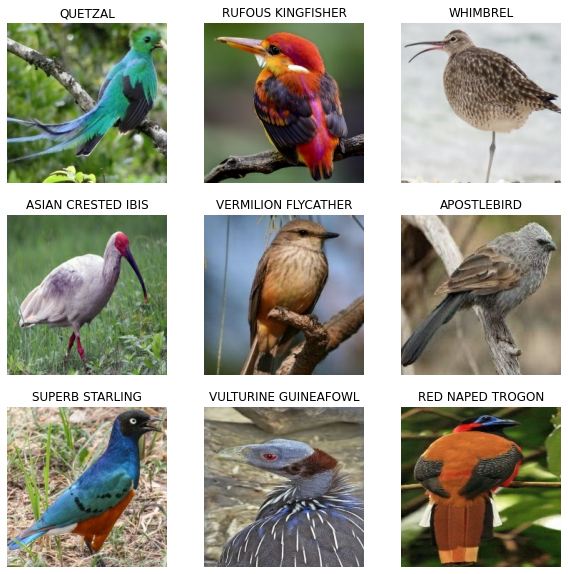

In [9]:
# Check the training dataset by loading the first 9 images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Preprocess the data

In [10]:
preprocessed_layer = tf.keras.layers.Rescaling(1./255)

In [11]:
preprocessed_ds = train_ds.map(lambda x, y: (preprocessed_layer(x), y))
image_batch, labels_batch = next(iter(preprocessed_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


### Configure the dataset for performance

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train the model

In [ ]:
# Create the model using function API
def convolutional_model(input_shape):

    img_input = tf.keras.Input(shape=(input_shape))

    Z1 = tfl.Conv2D(32,(4,4),strides=1,padding='same')(img_input)
    A1 = tfl.ReLU()(Z1)
    P1 = tfl.MaxPool2D(pool_size=(8,8),strides=8,padding='same')(A1)
    Z2 = tfl.Conv2D(16,(2,2),strides=1,padding='same')(P1)
    A2 = tfl.ReLU()(Z2)
    P2 = tfl.MaxPool2D(pool_size=(4,4),strides=4,padding='same')(A2)
    F = tfl.Flatten()(P2)
    outputs = tfl.Dense(400,activation='softmax')(F)

    model = tf.keras.Model(inputs=img_input, outputs=outputs)
    return model

conv_model = convolutional_model((224, 224, 3))
conv_model.compile(optimizer = 'adam',
                   loss = tf.losses.SparseCategoricalCrossentropy(),
                   metrics = ['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                            patience = 3,
                                            restore_best_weights = True )                  

conv_model.summary()

history = conv_model.fit(train_ds, epochs = 5, validation_data=valid_ds, callbacks=[callback])

In [ ]:
# Create the model using transfer learning
resnet = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling='avg')


for layer in resnet.layers:
    layer.trainable = False

resnet = tf.keras.Sequential([resnet,
                              tfl.Flatten(),
                              tfl.Dropout(0.3),
                              tfl.Dense(400, activation='softmax')])

resnet.compile(optimizer = 'adam',
               loss = tf.losses.SparseCategoricalCrossentropy(),
               metrics = ['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                            patience = 3,
                                            restore_best_weights = True)                  

resnet.summary()

history = resnet.fit(train_ds, epochs = 5, validation_data=valid_ds, callbacks=[callback])


In [ ]:
# To be continued with solutions to GPU solving 400 classes classification